In [1]:
from datetime import datetime
import tarfile
import json
import bz2
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
start_time = datetime.now()

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, desc, min, max, to_timestamp, to_date, date_format, col, expr, hour, year, month, dayofweek, count
from pyspark.sql import functions as F #module that includes a variety of functions like to extract features

In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [5]:
#viewing dataset as pd df
columns = ["index", "id", "date", "flag", "user", "text"]
pdDf = pd.read_csv("ProjectTweets.csv", header=None, names=columns)

pdDf

,index,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Loading csv data file to spark

In [6]:
# Issue with pattern in the DateTimeFormatter when converting to timestamp due to spark version. Setting timeParserPolicy to LEGACY as the error suggested
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY") 

#defining schema
schema = StructType([
    StructField("index", StringType(), True),
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

tweetsDf= spark.read.csv('hdfs://localhost:9000/user1/ProjectTweets.csv', schema=schema, header=False)

# converting date column to timestamp, pattern taken from https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html
tweetsDf= tweetsDf.withColumn("date", to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy"))

tweetsDf.printSchema();tweetsDf.show()

root
 |-- index: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



+-----+----------+-------------------+--------+---------------+--------------------+
|index|        id|               date|    flag|           user|                text|
+-----+----------+-------------------+--------+---------------+--------------------+
|    0|1467810369|2009-04-07 06:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|1467810672|2009-04-07 06:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|2009-04-07 06:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|2009-04-07 06:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|2009-04-07 06:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
|    5|1467811372|2009-04-07 06:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|1467811592|2009-04-07 06:20:03|NO_QUERY|        mybirch|         Need a hug |
|    7|1467811594|2009-04-07 06:20:03|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|1467811795|2009-04-07 06:20:05|NO_QUERY|2Hood4Hollywood|@T

checking flag column

In [7]:
#extracting "flag" column as RDD, showing unique values with distinct funcion and showing with collect()
tweetsDf.select("flag").rdd.distinct().collect()

[Row(flag='NO_QUERY')]

In [8]:
# counting the number of duplicated IDs, grouping by id and filterring out rows where id count is 1. Then counting those rows
tweetsDf.groupBy("id").count().filter(col("count") > 1).count()

1685

In [9]:
#counting the number of duplicated rows, same as above but addind the remaining features except index because this one would always be different
tweetsDf.groupBy(["id", "date", "flag", "user", "text"]).count().filter(col("count") > 1).count()

1685

In [10]:
#number of rows
tweetsDf.count()

1600000

In [11]:
# dropping rows with duplicate IDs (keeping the first occurrence)
tweetsDf= tweetsDf.dropDuplicates(["id"])

In [12]:
#number of rows
tweetsDf.count()

1598315

#### Tweets in English

In [13]:
#!pip install langdetect

In [14]:
#importing library for language detection
from langdetect import detect

In [15]:
def detect_language(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'  # Return 'unknown' in case of an error with langdetect

# defining a user function (UDF)
detect_language_udf = udf(detect_language) 

# adding new column to label each tweet with a language
tweetsDf = tweetsDf.withColumn('language', detect_language_udf(col('text')))

In [16]:
# Filter out non-English tweets
TweetsDf = tweetsDf.filter(col('language') == 'en')

In [17]:
#dropping unnecessary columns
tweetsDf=tweetsDf.drop("flag","language")

Checking number of unique users and users with greatest count of tweets

In [18]:
# number of unique users as RDD, same as done with attribute 'flag'
tweetsDf.select("user").rdd.distinct().count()

659775

In [19]:
#users with greatest count of tweets
# registerring the df as a temporary view
tweetsDf.createOrReplaceTempView("tweets")

# SQL query, selecting user column and adding another column called count showing the counts in descendent order
query = """SELECT user, COUNT(*) as count
    FROM tweets
    GROUP BY user
    ORDER BY count DESC"""

# running the SQL query and showing result
spark.sql(query).show()

+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



### DATES

In [20]:
#Ordering rows by date
tweetsDf= tweetsDf.orderBy("date")
tweetsDf.show()

+-----+----------+-------------------+---------------+--------------------+
|index|        id|               date|           user|                text|
+-----+----------+-------------------+---------------+--------------------+
|    0|1467810369|2009-04-07 06:19:45|_TheSpecialOne_|@switchfoot http:...|
|    1|1467810672|2009-04-07 06:19:49|  scotthamilton|is upset that he ...|
|    2|1467810917|2009-04-07 06:19:53|       mattycus|@Kenichan I dived...|
|    3|1467811184|2009-04-07 06:19:57|        ElleCTF|my whole body fee...|
|    4|1467811193|2009-04-07 06:19:57|         Karoli|@nationwideclass ...|
|    5|1467811372|2009-04-07 06:20:00|       joy_wolf|@Kwesidei not the...|
|    7|1467811594|2009-04-07 06:20:03|           coZZ|@LOLTrish hey  lo...|
|    6|1467811592|2009-04-07 06:20:03|        mybirch|         Need a hug |
|    8|1467811795|2009-04-07 06:20:05|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|1467812025|2009-04-07 06:20:09|        mimismo|@twittera que me ...|
|   10|14678

In [21]:
# checking if the df is ordered by id
# aggregation on the df and calculation of the min and max values of parameter "id"
#checking if min_id < max_id, returning a df with a single Boolean value
# collect executes the transformations and select access row 0 column 0 from resulting df
tweetsDf.agg(F.min("id").alias("min_id"), F.max("id").alias("max_id")) \
                    .select(F.col("min_id") < F.col("max_id")) \
                    .collect()[0][0]

# True confirms the df is ordered by id

True

In [22]:
# is the df ordered by index? Same code as above
tweetsDf.agg(F.min("index").alias("min_index"), F.max("index").alias("max_index")) \
                    .select(F.col("min_index") < F.col("max_index")) \
                    .collect()[0][0]

True

In [23]:
oldestDate, latestDate = tweetsDf.select(min("date"), max("date")).first()
print('minimum date: ',oldestDate,'\nmaximum date: ',latestDate)

minimum date:  2009-04-07 06:19:45 
maximum date:  2009-06-25 18:28:31


#### DATES COUNTS DF

In [24]:
#timestamps with greatest count of tweets. Extracting timestamps with module 'functions' and aggregating counts, which are shown in a new column, descendent ordered  
tweetsDf.groupBy('date').agg(F.count('*').alias('count')).orderBy(F.desc('count')).show()

+-------------------+-----+
|               date|count|
+-------------------+-----+
|2009-06-15 20:53:14|   20|
|2009-05-22 13:10:17|   17|
|2009-06-15 21:39:50|   17|
|2009-05-29 21:40:04|   17|
|2009-06-05 19:05:33|   16|
|2009-06-05 22:13:07|   16|
|2009-05-29 18:09:34|   15|
|2009-06-01 20:25:21|   15|
|2009-05-30 15:53:15|   15|
|2009-06-06 19:59:49|   15|
|2009-06-05 17:45:09|   15|
|2009-06-01 23:19:07|   15|
|2009-05-22 16:34:27|   15|
|2009-06-05 22:17:04|   15|
|2009-06-15 18:39:32|   15|
|2009-05-30 05:11:33|   14|
|2009-05-31 05:07:22|   14|
|2009-06-07 23:07:45|   14|
|2009-05-30 18:17:56|   14|
|2009-06-03 14:52:51|   14|
+-------------------+-----+
only showing top 20 rows



In [25]:
#same as above but excluding seconds, using date_format and extracting date, hours and minutes only
tweetsDf.groupBy(
    F.date_format('date', 'yyyy-MM-dd').alias('date'),
    F.date_format('date', 'HH').alias('hour'),
    F.date_format('date', 'MM').alias('minute')
).agg(F.count('*').alias('count')).orderBy(F.desc('count')).show() #aggregating counts of timestamps (tweets) producing a new column

+----------+----+------+-----+
|      date|hour|minute|count|
+----------+----+------+-----+
|2009-05-17|  19|    05| 8075|
|2009-06-06|  16|    06| 5478|
|2009-06-06|  17|    06| 5394|
|2009-06-07|  03|    06| 5097|
|2009-06-01|  15|    06| 5048|
|2009-06-16|  05|    06| 5043|
|2009-05-31|  05|    05| 5037|
|2009-05-17|  18|    05| 5037|
|2009-06-01|  16|    06| 5029|
|2009-06-07|  01|    06| 5020|
|2009-06-16|  01|    06| 5012|
|2009-05-31|  18|    05| 5008|
|2009-06-01|  23|    06| 5006|
|2009-06-01|  00|    06| 5004|
|2009-05-30|  19|    05| 5003|
|2009-05-31|  23|    05| 4993|
|2009-06-07|  00|    06| 4983|
|2009-06-01|  01|    06| 4983|
|2009-06-02|  00|    06| 4979|
|2009-06-16|  03|    06| 4979|
+----------+----+------+-----+
only showing top 20 rows



#### Natural hours per day that hold tweets

In [26]:
#grouping by date and count unique hours. Extranting features with module 'functions'. Counts the unique hours per day and aggregates the totals in a new column
hourlyPerDay = tweetsDf.groupBy(F.to_date('date').alias('date')).agg(F.countDistinct(F.hour('date')).alias('uniqueHourCount'))

hourlyPerDay.orderBy(desc('uniqueHourCount')).show() 

+----------+---------------+
|      date|uniqueHourCount|
+----------+---------------+
|2009-06-20|             24|
|2009-05-30|             24|
|2009-06-19|             24|
|2009-06-02|             24|
|2009-06-17|             24|
|2009-06-16|             24|
|2009-06-06|             24|
|2009-05-31|             24|
|2009-06-07|             24|
|2009-06-18|             23|
|2009-06-01|             21|
|2009-04-19|             19|
|2009-06-03|             19|
|2009-06-21|             18|
|2009-06-15|             18|
|2009-05-02|             18|
|2009-05-17|             18|
|2009-05-10|             17|
|2009-05-03|             16|
|2009-05-18|             16|
+----------+---------------+
only showing top 20 rows



In [27]:
#checking percentiles
hourlyPerDay.toPandas().describe(percentiles=[0.25, 0.5, 0.75])

,uniqueHourCount
count,41.000000
mean,14.463415
std,7.691221
min,1.000000
25%,7.000000
50%,16.000000
75%,21.000000
max,24.000000


In [28]:
#Confirmation of missing dates:
print(' Between\n',oldestDate,'\n and\n',latestDate,'\nthere are\n',latestDate - oldestDate)


#generating the list of dates. 86400 s/day
timeRange = spark.range(start=oldestDate.strftime("%s"), end=latestDate.strftime("%s"), step=86400).selectExpr("to_date(from_unixtime(id)) as date")



#Listing missing dates with anti-join between the date range and the 'date' column. 
missingDates= timeRange.join(tweetsDf, timeRange.date == tweetsDf.date.cast(DateType()), 'leftanti') # leftanti selects the rows from the left df that do not have a matching key from the right df


print(" there are missing dates ->",missingDates.count());missingDates.show(missingDates.count())

 Between
 2009-04-07 06:19:45 
 and
 2009-06-25 18:28:31 
there are
 79 days, 12:08:46


 there are missing dates -> 39


+----------+
|      date|
+----------+
|2009-04-08|
|2009-04-09|
|2009-04-10|
|2009-04-11|
|2009-04-12|
|2009-04-13|
|2009-04-14|
|2009-04-15|
|2009-04-16|
|2009-04-17|
|2009-04-22|
|2009-04-23|
|2009-04-24|
|2009-04-25|
|2009-04-26|
|2009-04-27|
|2009-04-28|
|2009-04-29|
|2009-04-30|
|2009-05-01|
|2009-05-05|
|2009-05-06|
|2009-05-07|
|2009-05-08|
|2009-05-09|
|2009-05-13|
|2009-05-15|
|2009-05-16|
|2009-05-19|
|2009-05-20|
|2009-05-21|
|2009-05-23|
|2009-05-26|
|2009-05-28|
|2009-06-09|
|2009-06-10|
|2009-06-11|
|2009-06-12|
|2009-06-13|
+----------+



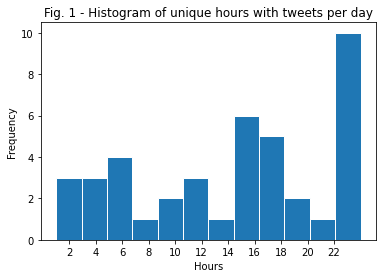

In [29]:
#transforming to pandas for the histogram 
plt.hist(hourlyPerDay.toPandas()['uniqueHourCount'], bins=12, edgecolor='white')

#Arranging axis labels, ticks, title
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.xticks(np.arange(2,24,2)) #Adjusting xticks to the bins
plt.title('Fig. 1 - Histogram of unique hours with tweets per day')

plt.show()

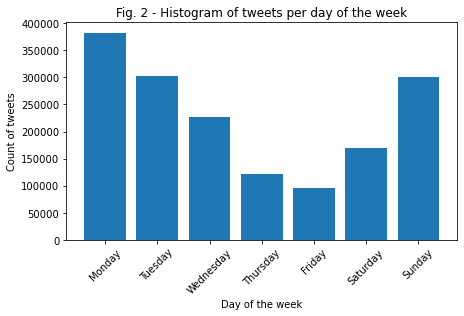

In [30]:
#extracting each of the days of the week
tweetsDf= tweetsDf.withColumn('day_of_week', dayofweek('date'))

# counting number of tweets by day of the week by adding a new column
tweetCounts= tweetsDf.groupBy('day_of_week').agg(count('*').alias('count'))


dayLabels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(7, 4))#setting size of plot
plt.bar(tweetCounts.toPandas()['day_of_week'], tweetCounts.toPandas()['count'])#need to convert to pandas

#Arranging axis labels, ticks, title
plt.xlabel('Day of the week')
plt.ylabel('Count of tweets')
plt.title('Fig. 2 - Histogram of tweets per day of the week')
plt.xticks(range(1, 8), dayLabels, rotation=45)
plt.show()

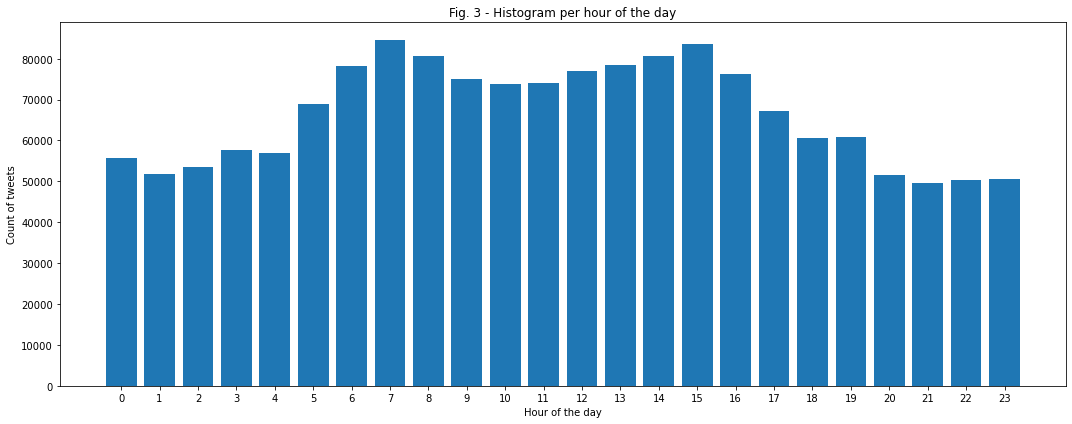

In [31]:
#extracting each of the 24 hours of a day
tweetsDf= tweetsDf.withColumn('hour_of_day', hour('date'))

#adding column with counts
tweetCounts= tweetsDf.groupBy('hour_of_day').agg(count('*').alias('count'))


plt.figure(figsize=(15, 6))
plt.bar(tweetCounts.toPandas()['hour_of_day'], tweetCounts.toPandas()['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Count of tweets')
plt.title('Fig. 3 - Histogram per hour of the day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

## Text

In [32]:
# converting to RDD, descriptive part
tweetsRdd = tweetsDf.rdd

In [33]:
#counting number of characters in text field of each row. Values stored in a list
charCounts= tweetsRdd.map(lambda row: len(row.text)).collect()
sum(charCounts) / len(charCounts)

74.06687104857303

In [34]:
#counting the number of words in each tweet by splitting text. List created
wordCounts= tweetsRdd.map(lambda row: len(row.text.split())).collect()

In [35]:
#number of words
sum(wordCounts)

21052270

In [36]:
#average number of words per tweet
sum(wordCounts)/len(wordCounts)

13.171540028092085

In [37]:
#standar deviation
np.std(wordCounts)

6.957362523703989

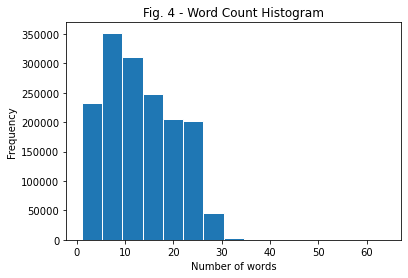

In [38]:
#plotting the histogram
plt.hist(wordCounts, bins=15, edgecolor='white')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Fig. 4 - Word Count Histogram')
plt.show()

In [39]:
#Checking % of upper case words
allWords= tweetsRdd.flatMap(lambda row: row.text.split())
uppercaseWords= allWords.filter(lambda word: word.isupper())

#proportion
uppercaseWords.count() / allWords.count()

0.04626246955791466

### checking most common words

In [40]:
#extracting all words from the tweets, splitting text with a single space
words= tweetsRdd.flatMap(lambda tweet: tweet[4].split(" ")) # flatMap flattens the RDD after applying the function on column 4 (text). Returns one single collection instead of a collection of collections (like one dimension)

#Filtering words with >3 characters
filteredWords= words.filter(lambda word: len(word) > 4)



#counting totals per word, case insensitive
wordCounts = filteredWords.map(lambda word: (word.lower(), 1)).reduceByKey(lambda a, b: a + b) # reduceByKey merges the values for each key using an associative and commutative reduce function

In [41]:
# sorting in descending order
sortedWordCounts= wordCounts.sortBy(lambda x: x[1], ascending=False)

# taking the top 50 words with the highest counts
topWords= sortedWordCounts.take(50)

topWords

going  -  62205
about  -  48654
don't  -  48025
really  -  46113
can't  -  44233
still  -  41358
&amp;  -  40077
think  -  38906
today  -  36471
thanks  -  30152
there  -  29241
night  -  27654
great  -  27189
would  -  26096
getting  -  24020
twitter  -  23580
happy  -  23536
gonna  -  23381
watching  -  22136
morning  -  21713
should  -  21508
right  -  21380
that's  -  21124
could  -  20802
didn't  -  19874
sorry  -  19870
tomorrow  -  19809
you're  -  18975
sleep  -  18728
after  -  18071
better  -  17807
thank  -  17482
never  -  17326
people  -  16830
again  -  16506
wanna  -  16278
little  -  16259
having  -  15819
being  -  15731
first  -  15228
school  -  14846
watch  -  14779
doing  -  14529
working  -  14311
feeling  -  14107
always  -  14059
another  -  14023
tonight  -  13383
though  -  13370
because  -  13275


In [88]:
# getting a simple list from the 2-dimensional list of tuples topWords, with words with highest count and potential to be removed. Getting first element from all tuples
topWordsRemoval = [i[0] for i in topWords][0:]
topWordsRemoval

['going',
 'about',
 "don't",
 'really',
 "can't",
 'still',
 '&amp;',
 'think',
 'today',
 'thanks',
 'there',
 'night',
 'great',
 'would',
 'getting',
 'twitter',
 'happy',
 'gonna',
 'watching',
 'morning',
 'should',
 'right',
 "that's",
 'could',
 "didn't",
 'sorry',
 'tomorrow',
 "you're",
 'sleep',
 'after',
 'better',
 'thank',
 'never',
 'people',
 'again',
 'wanna',
 'little',
 'having',
 'being',
 'first',
 'school',
 'watch',
 'doing',
 'working',
 'feeling',
 'always',
 'another',
 'tonight',
 'though',
 'because']

In [93]:
# removing words with potential impact on sentiment score from the list before
wordsToRemove = [i for idx, i in enumerate(topWordsRemoval) if idx not in [2, 3, 4, 9, 12, 14, 16, 20, 21, 23, 24, 25, 30, 31, 32, 34, 44]]
wordsToRemove

['going',
 'about',
 'still',
 '&amp;',
 'think',
 'today',
 'there',
 'night',
 'would',
 'twitter',
 'gonna',
 'watching',
 'morning',
 "that's",
 'tomorrow',
 "you're",
 'sleep',
 'after',
 'people',
 'wanna',
 'little',
 'having',
 'being',
 'first',
 'school',
 'watch',
 'doing',
 'working',
 'always',
 'another',
 'tonight',
 'though',
 'because']

In [43]:
#checking rare words, excluding URLs,@ and #
rareWords= sortedWordCounts.top(50, key=lambda x: -x[1] if not (x[0].startswith("http://") or x[0].startswith("@") or x[0].startswith("#")) else float("-inf"))

# Printing the top words
for word, count in rareWords:
    print(word,' - ',count)

,only  -  1
premiere?!  -  1
snyder's  -  1
doucheclown.  -  1
twanking  -  1
uids?  -  1
www.diigo.com/~tautao  -  1
acm's?!  -  1
men?!?!?  -  1
'blood  -  1
makakasama  -  1
wagah  -  1
noodlebox  -  1
yourself...we  -  1
crunches!  -  1
nikster...  -  1
awesome&lt;3  -  1
shorts.......and  -  1
asba's  -  1
hopin..  -  1
-lauren  -  1
16-mo-old  -  1
agh...snow!!!  -  1
peddies  -  1
freezer-worthy  -  1
(shit,  -  1
9th&amp;10th  -  1
shhhhhhhhhh....time  -  1
sietar...  -  1
manual...  -  1
phantasy  -  1
house...house  -  1
letters,too.hope  -  1
fine?i  -  1
dog,sheï¿½s  -  1
wiggety-whack.  -  1
:*(:*(:*(  -  1
match....reached  -  1
roflmao...  -  1
ackin'  -  1
we....  -  1
x:drive  -  1
please?:  -  1
heah!  -  1
more!the  -  1
unison&amp;  -  1
babiiesss  -  1
grebel  -  1
*thats  -  1
tuesdayï¿½ll  -  1


### checking hashtags

In [44]:
#extracting hashtags from the tweets, splitting text with single space, considering words which start with #
hashtagsRdd = tweetsRdd.flatMap(lambda tweet: tweet[4].split(" ")).filter(lambda word: word.startswith("#")) # flatMap flattens the RDD after applying the function on column 4 (text). Returns one single collection instead of a collection of collections (like one dimension)

# counting totals per hashtag, case insensitive with .lower()
hashtagsTotal= hashtagsRdd.map(lambda hashtag: (hashtag.lower(), 1)).reduceByKey(lambda a, b: a + b)

In [45]:
#top 50 hashtags
topHashtags= hashtagsTotal.takeOrdered(50, key=lambda x: -x[1])

In [46]:
topHashtags

[('#followfriday', 2286),
 ('#fb', 1762),
 ('#squarespace', 866),
 ('#ff', 822),
 ('#seb-day', 498),
 ('#iranelection', 485),
 ('#', 472),
 ('#musicmonday', 396),
 ('#1', 391),
 ('#fail', 343),
 ('#asot400', 320),
 ('#iphone', 296),
 ('#iremember', 293),
 ('#bsb', 288),
 ('#myweakness', 262),
 ('#marsiscoming', 255),
 ('#f1', 244),
 ('#bgt', 236),
 ('#e3', 232),
 ('#mcflyforgermany', 230),
 ('#2', 214),
 ('#andyhurleyday', 187),
 ('#inaperfectworld', 172),
 ('#haveyouever', 168),
 ('#delongeday', 164),
 ('#mileymonday', 160),
 ('#spymaster', 156),
 ('#tcot', 155),
 ('#trackle', 155),
 ('#followfriday!', 141),
 ('#goodsex', 120),
 ('#chuckmemondays', 110),
 ('#hhrs', 105),
 ('#xboxe3', 104),
 ('#dontyouhate', 104),
 ('#mmwanted', 102),
 ('#bradiewebb', 102),
 ('#clothdiapers', 102),
 ('#twitter', 102),
 ('#flylady', 96),
 ("#tag'", 92),
 ('#chesterday', 92),
 ('#asylm', 92),
 ('#eu09', 90),
 ('#follow', 89),
 ('#bts', 88),
 ('#tweetdeck', 86),
 ('#shortstack', 86),
 ('#hoppusday', 84),


In [47]:
#Checking the number of numerics. flatMap applys a function to all elements and returns one single collection
tweetsRdd.flatMap(lambda row: list(filter(lambda char: char.isdigit(), row.text))).count() # filterring out numeric characters

850081

#### Number of stopwords

In [49]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [50]:
#getting stopwords for English language
stopwordsBag= set(stopwords.words('english'))

#splitting text field to single words, filterring stopwords only and counting them
tweetsRdd.flatMap(lambda row: row.text.lower().split()).filter(lambda word: word in stopwordsBag).count() # flatMap returns one single collection instead of a collection of collections (like one dimension)

8093693

In [51]:
#number of special characters
#filterring out non-alphanumeric characters. isalnum() returns True if all characters in the string are alphanumeric. Creating a new list convert them into a list.
tweetsRdd.flatMap(lambda row: list(filter(lambda char: not char.isalnum(), row.text))).count()

27809083

#### data CLEANING

In [100]:
import re # regular expressions
from pyspark.ml.feature import StopWordsRemover
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from pyspark.sql import Row
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [62]:
# stopwords for English
stopwords = set(stopwords.words('english'))

In [109]:
# Cleaning up tweets
def clean_text(row):
    
    #selecting the column text
    text = row.text

    # multiple regex combined with | (OR) to remove URLs, hashtags, user mentions, special characters (except aprostrophes between 'n' & 't' so that textBlob handles negations correctly), single characters and extra white spaces
    # combined in one line of code to improve performance
    text = re.sub(r'http\S+|www\S+|#\w+|@\w+|[^a-zA-Z0-9]|(?<!n)\'(?!t)|\s+|\b\w\b', ' ', text)


    #tokenizing text into words
    tokens = word_tokenize(text)

    # removing stopwords, common words and making it lower case
    woTokens = [token.lower() for token in tokens if token.lower() not in stopwords and token.lower() not in wordsToRemove]

    
    # spelling correction
    corrected_tokens = [str(TextBlob(token).correct()) for token in woTokens]

    # lemmatizing words
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in corrected_tokens]

    # joining tokens back
    cleaned_text = ' '.join(lemmatized_tokens)

    return Row(id=row.id, date=row.date, user=row.user, text=cleaned_text)

In [111]:
# applying function to the RDD
cleanedRdd = tweetsRdd.map(clean_text)

In [119]:
# sample of 50 tweets
for row in cleanedRdd.take(50):
    print(row.text)

summer should got david care third day
upset update facebook testing might cry result also bah
dived many time ball managed save 50 rest go bound
whole body feel itchy like fire
behaving mad see
whole crew
need hug
hey long time see yes rain bit bit ll fine thanks
hope
que mere
spring break plain city showing
pierced ear
bear thought a loss embarrassing
count ink either never talk anymore
wish got miss premier
gun really sac under doucheclown
holmes death scene hurt severely film wry director cut
file tax
ah give wanted see rent love soundtrack
oh dear drinking forgotten table drink
day get much done
one friend called asked meet mid valley time sigh
baked cake acted
week hoped
black class
hate call wake
cry barley
in sad miss silly
oooh ll leslie ok leslie get mad
me almost lover exception track get depressed every time
want go promote gear groove unfortunately ride may one anaheim may
some hacked account aim make new one
thought sleeping option realizing evaluation work afternoon
awe 

### Assigning a sentiment score

In [120]:
#!pip install textblob

In [121]:
def sentimentScore(row):
    
    text = row.text
    

    # Creating TextBlob object
    blob = TextBlob(text)

    # Getting polarity score
    polarity = blob.sentiment.polarity

    # Updating row with sentiment score
    return Row(id=row.id, date=row.date, user=row.user, text=row.text, sentimentScore=polarity)

In [122]:
#applying function
sentimentRdd = cleanedRdd.map(sentimentScore)

In [123]:
sentimentRdd.first()

Row(id='1467810369', date=datetime.datetime(2009, 4, 7, 6, 19, 45), user='_TheSpecialOne_', text='summer should got david care third day', sentimentScore=0.0)

In [125]:
start_time = datetime.now()

In [ ]:
# number of tweets
tweetsNumber = sentimentRdd.count()


#tweets with score > 0.3 (+ sentiment)
positiveTweets = sentimentRdd.filter(lambda row: row.sentimentScore > 0.33).count()

# tweets with score < -0.3 (- sentiment)
negativeTweets = sentimentRdd.filter(lambda row: row.sentimentScore < -0.33).count()


# proportions
positivePercent = (positiveTweets / tweetsNumber)*100
negativePercent = (negativeTweets / tweetsNumber)*100

In [ ]:
end_time = datetime.now()
end_time - start_time

In [ ]:
print(round(positivePercent,1),'% of tweets with positive sentiment')
print(round(negativePercent,1),'% of tweets with negative sentiment')
print(round(100-positivePercent-negativePercent,1),'% of tweets with neutral sentiment')

## YCSB

In [35]:
mongoDf = pd.read_csv('YCSB.csv',skiprows=1,nrows=24)
mongoDf

,MongoDB,units,wa-1k,wa-5k,wa-10k,wa-20k,wa-50k,wb-1k,wb-5k,wb-10k,wb-20k,wb-50k
0,[OVERALL],RunTime(ms),1121.00000,3864.000000,2010.000000,2470.000000,4571.00000,1076.00000,3727.000000,1891.000000,2597.000000,4458.00000
1,[OVERALL],Throughput(ops/sec),892.06066,1293.995859,4975.124378,8097.165992,10938.52549,929.36803,1341.561578,5288.207298,7701.193685,11215.79183
2,[TOTAL_GCS_Copy],Count,0.00000,1.000000,3.000000,5.000000,12.00000,0.00000,1.000000,3.000000,5.000000,12.00000
3,[TOTAL_GC_TIME_Copy],Time(ms),0.00000,21.000000,15.000000,15.000000,17.00000,0.00000,16.000000,14.000000,19.000000,19.00000
4,[TOTAL_GC_TIME_%_Copy],Time(%),0.00000,0.543478,0.746269,0.607287,0.37191,0.00000,0.429300,0.740349,0.731613,0.42620
5,[TOTAL_GCS_MarkSweepCompact],Count,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000
6,[TOTAL_GC_TIME_MarkSweepCompact],Time(ms),0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000
7,[TOTAL_GC_TIME_%_MarkSweepCompact],Time(%),0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000
8,[TOTAL_GCs],Count,0.00000,1.000000,3.000000,5.000000,12.00000,0.00000,1.000000,3.000000,5.000000,12.00000
9,[TOTAL_GC_TIME],Time(ms),0.00000,21.000000,15.000000,15.000000,17.00000,0.00000,16.000000,14.000000,19.000000,19.00000


In [36]:
mysqlDf = pd.read_csv('YCSB.csv',skiprows=27)
mysqlDf

,MySQL,units,wa-1k,wa-5k,wa-10k,wa-20k,wa-50k,wb-1k,wb-5k,wb-10k,wb-20k,wb-50k
0,[OVERALL],RunTime(ms),11813.000000,16632.000000,57097.000000,159441.000000,498259.000000,11680.000000,60631.000000,66582.000000,174607.000000,517619.000000
1,[OVERALL],Throughput(ops/sec),84.652501,300.625301,175.140550,125.438250,100.349417,85.616438,82.466065,150.190742,114.542945,96.596145
2,[TOTAL_GCS_Copy],Count,0.000000,1.000000,3.000000,6.000000,15.000000,0.000000,1.000000,3.000000,6.000000,15.000000
3,[TOTAL_GC_TIME_Copy],Time(ms),0.000000,8.000000,11.000000,12.000000,14.000000,0.000000,14.000000,12.000000,12.000000,19.000000
4,[TOTAL_GC_TIME_%_Copy],Time(%),0.000000,0.048100,0.019265,0.007526,0.002810,0.000000,0.023090,0.018023,0.006873,0.003671
5,[TOTAL_GCS_MarkSweepCompact],Count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,[TOTAL_GC_TIME_MarkSweepCompact],Time(ms),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,[TOTAL_GC_TIME_%_MarkSweepCompact],Time(%),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,[TOTAL_GCs],Count,0.000000,1.000000,3.000000,6.000000,15.000000,0.000000,1.000000,3.000000,6.000000,15.000000
9,[TOTAL_GC_TIME],Time(ms),0.000000,8.000000,11.000000,12.000000,14.000000,0.000000,14.000000,12.000000,12.000000,19.000000


In [37]:
mysqlDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MySQL   24 non-null     object 
 1   units   24 non-null     object 
 2   wa-1k   24 non-null     float64
 3   wa-5k   24 non-null     float64
 4   wa-10k  24 non-null     float64
 5   wa-20k  24 non-null     float64
 6   wa-50k  24 non-null     float64
 7   wb-1k   24 non-null     float64
 8   wb-5k   24 non-null     float64
 9   wb-10k  24 non-null     float64
 10  wb-20k  24 non-null     float64
 11  wb-50k  24 non-null     float64
dtypes: float64(10), object(2)
memory usage: 2.4+ KB


In [93]:
# selecting slices of data
mysql_data1 = mysqlDf.iloc[:1, 2:7]
mysql_data2 = mysqlDf.iloc[:1, 7:]

mongo_data1 = mongoDf.iloc[:1, 2:7]
mongo_data2 = mongoDf.iloc[:1, 7:]

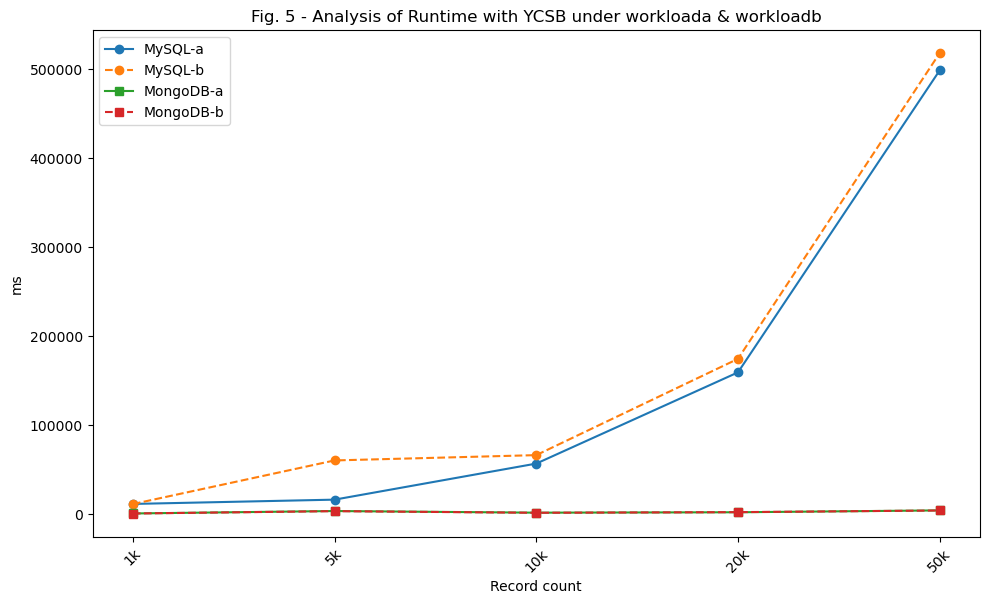

In [94]:
# creating a single figure with a subplot
fig, ax = plt.subplots(figsize=(10, 6))


# plotting each of the lines, a different marker per DB
mysql_data1.T.plot(ax=ax, marker='o', linestyle='-', markersize=6)
mysql_data2.T.plot(ax=ax, marker='o', linestyle='--', markersize=6)
mongo_data1.T.plot(ax=ax, marker='s', linestyle='-', markersize=6)
mongo_data2.T.plot(ax=ax, marker='s', linestyle='--', markersize=6)

# tunning axis
ax.set_title('Fig. 5 - Analysis of Runtime with YCSB under workloada & workloadb')
ax.set_xlabel('Record count')
ax.set_ylabel('ms') 

ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(["1k", "5k", "10k", "20k", "50k"])


# legend
ax.legend(["MySQL-a", "MySQL-b","MongoDB-a", "MongoDB-b"])

plt.tight_layout() # adjust layout
plt.xticks(rotation=45)
plt.show()

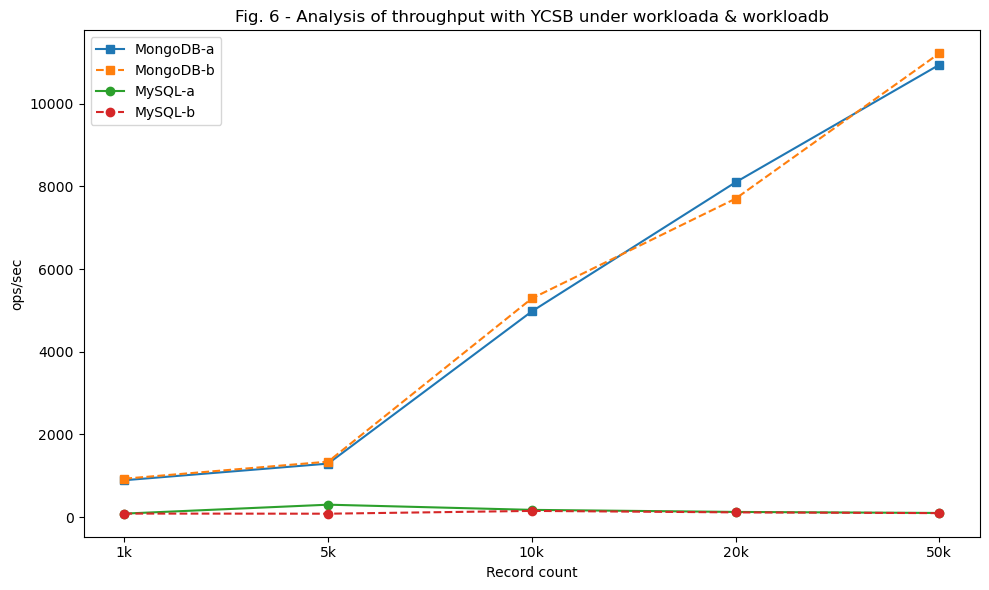

In [90]:
# selecting slices of data
mysql_data1 = mysqlDf.iloc[1:2, 2:7]
mysql_data2 = mysqlDf.iloc[1:2, 7:]

mongo_data1 = mongoDf.iloc[1:2, 2:7]
mongo_data2 = mongoDf.iloc[1:2, 7:]

# creating a single figure with a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# plotting each of the lines, a different marker per DB
mongo_data1.T.plot(ax=ax, marker='s', linestyle='-', markersize=6)
mongo_data2.T.plot(ax=ax, marker='s', linestyle='--', markersize=6)
mysql_data1.T.plot(ax=ax, marker='o', linestyle='-', markersize=6)
mysql_data2.T.plot(ax=ax, marker='o', linestyle='--', markersize=6)

ax.set_title('Fig. 6 - Analysis of throughput with YCSB under workloada & workloadb')
ax.set_xlabel('Record count')
ax.set_ylabel('ops/sec')

#custom x-axis, labels and ticks
xtick_labels = ["1k", "5k", "10k", "20k", "50k"]
xtick_positions = [0, 1, 2, 3, 4]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# legend
ax.legend(["MongoDB-a", "MongoDB-b","MySQL-a", "MySQL-b"])

plt.tight_layout() #adjust layout
plt.xticks()
plt.show()

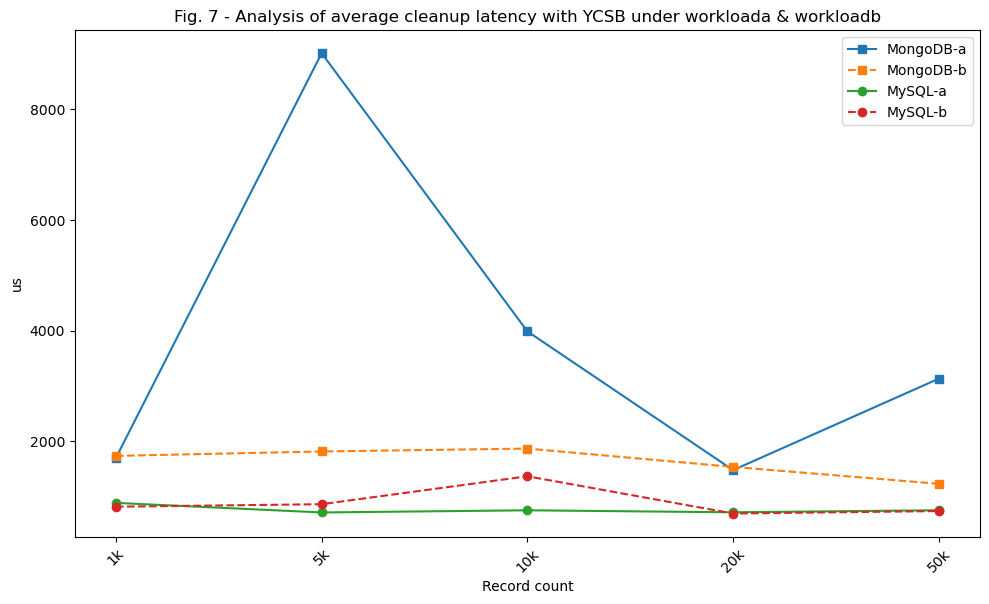

In [91]:
# selecting slices of data
mysql_data1 = mysqlDf.iloc[12:13, 2:7]
mysql_data2 = mysqlDf.iloc[12:13, 7:]

mongo_data1 = mongoDf.iloc[12:13, 2:7]
mongo_data2 = mongoDf.iloc[12:13, 7:]

# creating a single figure with a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# plotting each of the lines, a different marker per DB
mongo_data1.T.plot(ax=ax, marker='s', linestyle='-', markersize=6)
mongo_data2.T.plot(ax=ax, marker='s', linestyle='--', markersize=6)
mysql_data1.T.plot(ax=ax, marker='o', linestyle='-', markersize=6)
mysql_data2.T.plot(ax=ax, marker='o', linestyle='--', markersize=6)

ax.set_title('Fig. 7 - Analysis of average cleanup latency with YCSB under workloada & workloadb')
ax.set_xlabel('Record count')
ax.set_ylabel('us')

# Set custom x-axis, labels and ticks
xtick_labels = ["1k", "5k", "10k", "20k", "50k"]
xtick_positions = [0, 1, 2, 3, 4]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# legend
ax.legend(["MongoDB-a", "MongoDB-b","MySQL-a", "MySQL-b"])

plt.tight_layout() #adjust layout
plt.xticks(rotation=45)
plt.show()

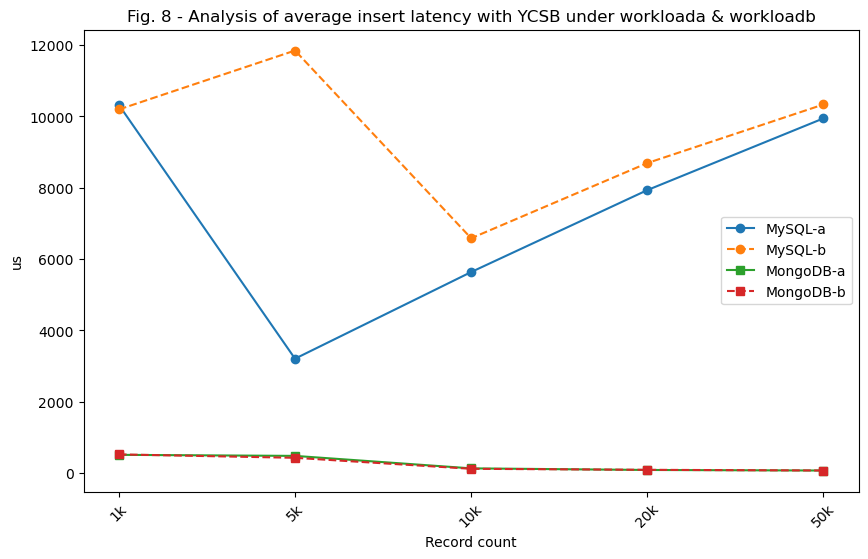

In [95]:
# selecting slices of data
mysql_data1 = mysqlDf.iloc[18:19, 2:7]
mysql_data2 = mysqlDf.iloc[18:19, 7:]

mongo_data1 = mongoDf.iloc[18:19, 2:7]
mongo_data2 = mongoDf.iloc[18:19, 7:]

# creating a single figure with a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# plotting each of the lines, a different marker per DB
mysql_data1.T.plot(ax=ax, kind='line', marker='o', linestyle='-', markersize=6)
mysql_data2.T.plot(ax=ax, kind='line', marker='o', linestyle='--', markersize=6)
mongo_data1.T.plot(ax=ax, kind='line', marker='s', linestyle='-', markersize=6)
mongo_data2.T.plot(ax=ax, kind='line', marker='s', linestyle='--', markersize=6)

ax.set_title('Fig. 8 - Analysis of average insert latency with YCSB under workloada & workloadb')
ax.set_xlabel('Record count')
ax.set_ylabel('us')

# Set custom x-axis, labels and ticks
xtick_labels = ["1k", "5k", "10k", "20k", "50k"]
xtick_positions = [0, 1, 2, 3, 4]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# legend
ax.legend(["MySQL-a", "MySQL-b","MongoDB-a", "MongoDB-b"])

plt.tight_layout() #adjust layout
plt.xticks(rotation=45)
plt.show()